# Event-Related Potentials (ERP) Analysis

Project Goal: Process MEG data and compute ERPs for auditory and visual stimuli

Skills covered:
- Loading raw data
- Filtering and preprocessing
- Event extraction
- Epoching
- ERP computation and visualization
- Topographic mapping

# Basic MNE-Python Project: Event-Related Potentials (ERP) Analysis

Project Goal: Process MEG data and compute ERPs for auditory and visual stimuli

Skills covered:
- Loading raw data
- Filtering and preprocessing
- Event extraction
- Epoching
- ERP computation and visualization
- Topographic mapping

## Step 1: Load the sample data

In [29]:
import mne
import numpy as np
import matplotlib.pyplot as plt

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder / 'MEG' / 'sample' / 'sample_audvis_raw.fif'

raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)
print(f"Data loaded: {raw.n_times} time points, {len(raw.ch_names)} channels")
print(f"Duration: {raw.times[-1]:.1f} seconds")
print(f"Sampling rate: {raw.info['sfreq']} Hz")

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Data loaded: 166800 time points, 376 channels
Duration: 277.7 seconds
Sampling rate: 600.614990234375 Hz


## Step 2: Explore the data structure

In [30]:
# Get channel types
channel_types = raw.get_channel_types()
print(f"Channel types: {set(channel_types)}")
print(f"MEG channels: {len([ch for ch in channel_types if 'mag' in ch or 'grad' in ch])}")
print(f"EEG channels: {channel_types.count('eeg')}")

Channel types: {'mag', 'stim', 'grad', 'eeg', 'eog'}
MEG channels: 306
EEG channels: 60


## Step 3: Filter the data

In [31]:
# Apply bandpass filter (1-40 Hz is typical for ERP analysis)
raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)
print("Applied bandpass filter: 1-40 Hz")

Applied bandpass filter: 1-40 Hz


## Step 4: Extract events

In [32]:
events = mne.find_events(raw_filtered, stim_channel='STI 014', verbose=False)
print(f"Found {len(events)} events")

# Define event IDs
event_id = {
    'auditory/left': 1,
    'auditory/right': 2,
    'visual/left': 3,
    'visual/right': 4
}

print("\nEvent types:")
for event_name, event_code in event_id.items():
    count = np.sum(events[:, 2] == event_code)
    print(f"  {event_name}: {count} trials")

Found 320 events

Event types:
  auditory/left: 72 trials
  auditory/right: 73 trials
  visual/left: 73 trials
  visual/right: 71 trials


## Step 5: Create epochs

In [33]:
# Epoch parameters
tmin, tmax = -0.2, 0.5  # Time before and after event
baseline = (None, 0)     # Baseline correction from start to event onset

epochs = mne.Epochs(
    raw_filtered,
    events,
    event_id,
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    preload=True,
    verbose=False
)

print(f"Created epochs: {len(epochs)} total")
print(f"Epoch duration: {tmin} to {tmax} seconds")
print(f"Baseline: {baseline}")

Created epochs: 289 total
Epoch duration: -0.2 to 0.5 seconds
Baseline: (None, 0)


## Step 6: Reject bad epochs (automatic artifact rejection)

In [34]:
# Define rejection thresholds
reject_criteria = dict(
    mag=4000e-15,     # 4000 fT
    grad=4000e-13,    # 4000 fT/cm
    eeg=150e-6        # 150 µV
)

epochs.drop_bad(reject=reject_criteria)
print(f"Epochs after rejection: {len(epochs)}")
print(f"Dropped {len(events) - len(epochs)} epochs")

    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 006', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 006', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 006', 'EEG 007', 'EEG 015']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecti

## Step 7: Compute ERPs (averaged evoked responses)

In [35]:
# Compute ERPs for each condition
evoked_dict = {}
for condition in event_id.keys():
    evoked_dict[condition] = epochs[condition].average()
    print(f"{condition}: averaged {len(epochs[condition])} epochs")

auditory/left: averaged 62 epochs
auditory/right: averaged 68 epochs
visual/left: averaged 72 epochs
visual/right: averaged 65 epochs


## Step 8: Visualize ERPs

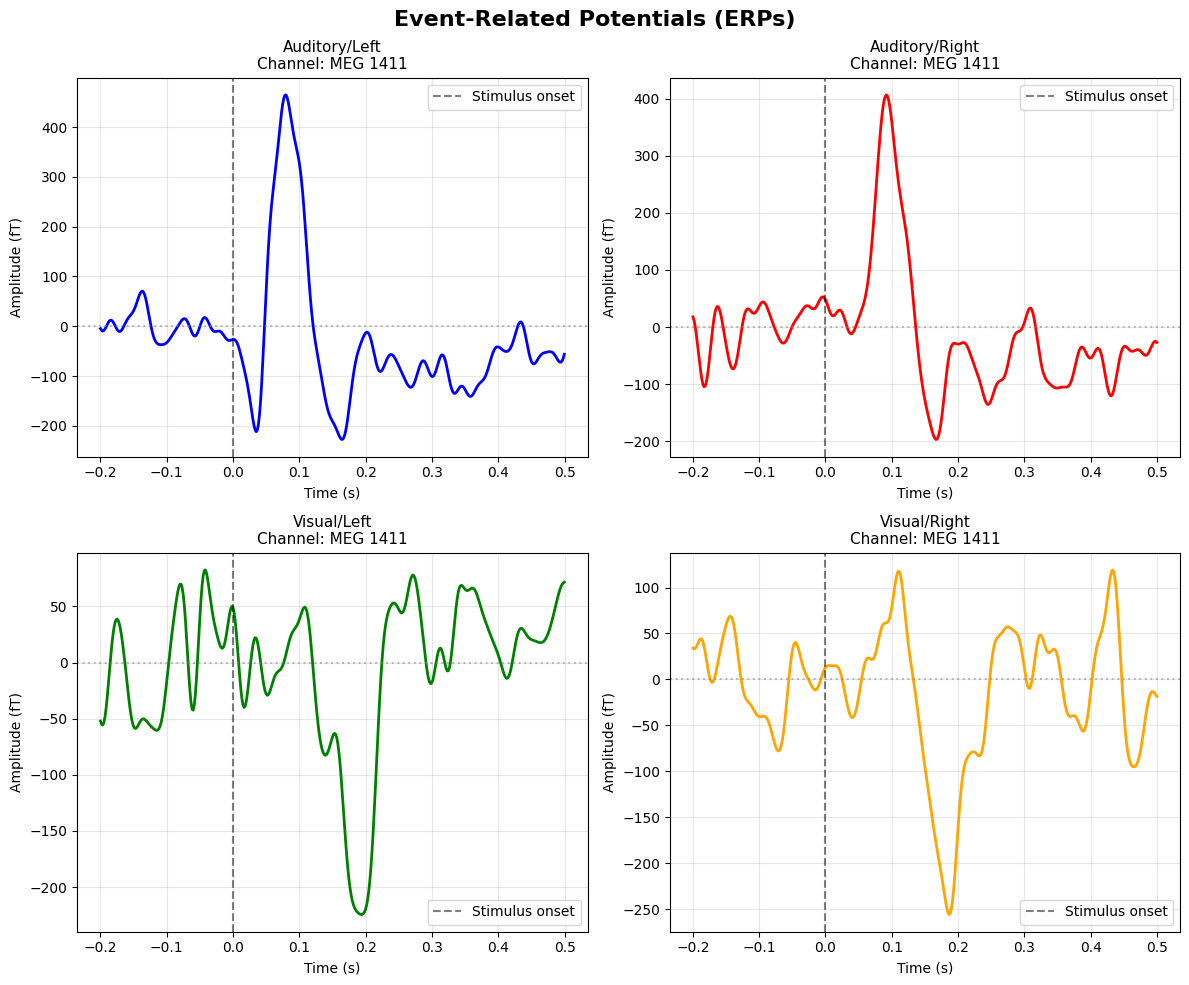

In [36]:
# Pick a representative MEG channel
picks = mne.pick_types(epochs.info, meg='mag', eeg=False)

# Plot ERPs for all conditions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Event-Related Potentials (ERPs)', fontsize=16, fontweight='bold')

conditions = list(event_id.keys())
colors = ['blue', 'red', 'green', 'orange']

for idx, (condition, color) in enumerate(zip(conditions, colors)):
    ax = axes[idx // 2, idx % 2]
    evoked = evoked_dict[condition]

    # Plot a single channel
    channel_idx = picks[50]  # Pick one magnetometer
    times = evoked.times
    data = evoked.data[channel_idx, :] * 1e15  # Convert to fT

    ax.plot(times, data, color=color, linewidth=2)
    ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Stimulus onset')
    ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Amplitude (fT)', fontsize=10)
    ax.set_title(f'{condition.title()}\nChannel: {evoked.ch_names[channel_idx]}', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

## Step 9: Topographic maps

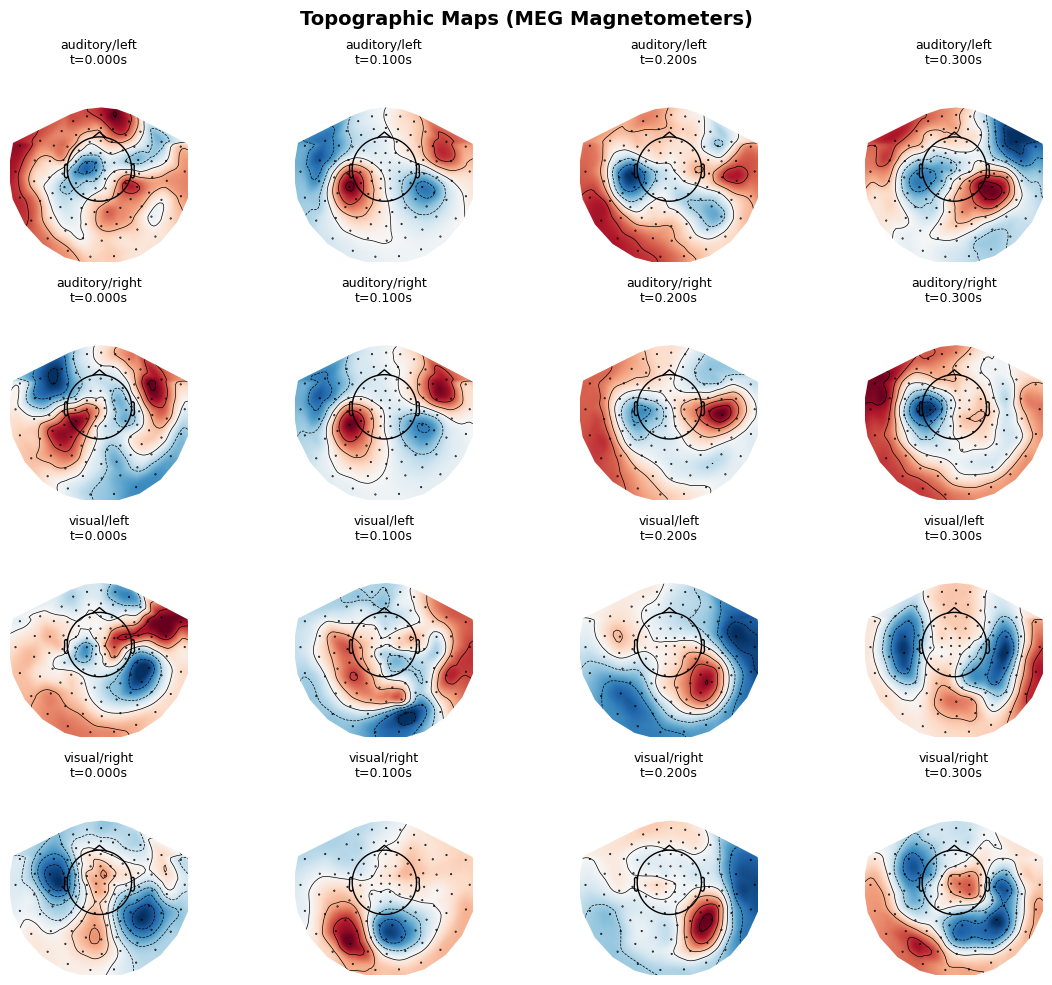

In [37]:
# Plot topographic maps at different time points
times_to_plot = [0.0, 0.1, 0.2, 0.3]

fig, axes = plt.subplots(len(conditions), len(times_to_plot),
                         figsize=(12, 10))
fig.suptitle('Topographic Maps (MEG Magnetometers)', fontsize=14, fontweight='bold')

for row_idx, condition in enumerate(conditions):
    evoked = evoked_dict[condition]
    for col_idx, t in enumerate(times_to_plot):
        ax = axes[row_idx, col_idx]

        # Pick only magnetometers for topomap
        mag_info = mne.pick_info(evoked.info, mne.pick_types(evoked.info, meg='mag', eeg=False))

        # Plot topomap
        mne.viz.plot_topomap(
            evoked.data[mne.pick_types(evoked.info, meg='mag', eeg=False), np.argmin(np.abs(evoked.times - t))],
            mag_info,
            axes=ax,
            show=False,
            ch_type='mag'
        )
        ax.set_title(f'{condition}\nt={t:.3f}s', fontsize=9)

plt.tight_layout()
plt.show()

## Step 10: Compare conditions

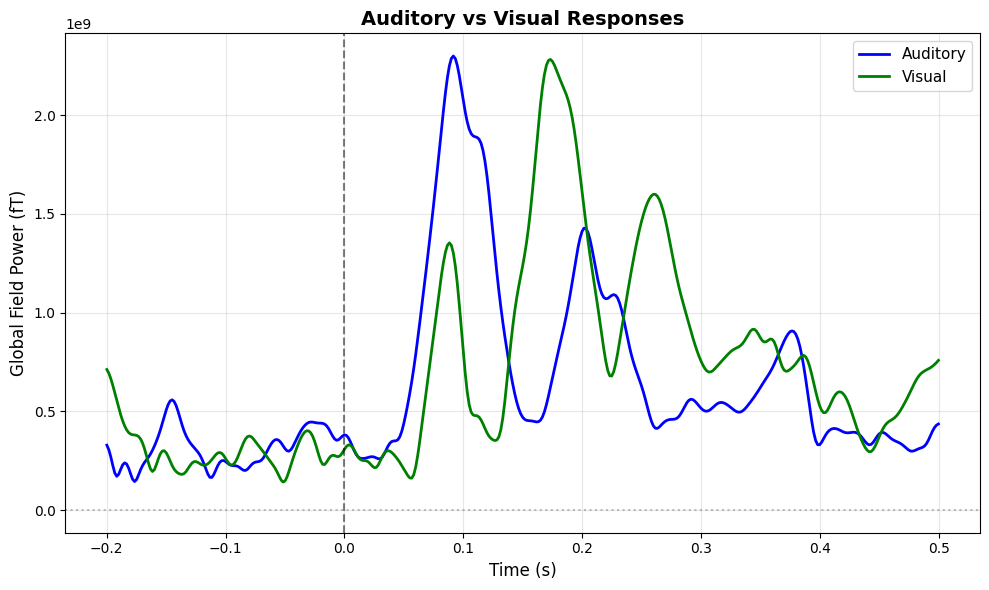

In [38]:
# Compare auditory vs visual
fig, ax = plt.subplots(figsize=(10, 6))

# Average across all auditory and visual conditions
auditory = mne.combine_evoked([evoked_dict['auditory/left'],
                                evoked_dict['auditory/right']],
                               weights='equal')
visual = mne.combine_evoked([evoked_dict['visual/left'],
                              evoked_dict['visual/right']],
                             weights='equal')

# Plot global field power (GFP)
times = auditory.times
gfp_auditory = np.sqrt(np.mean(auditory.data ** 2, axis=0)) * 1e15
gfp_visual = np.sqrt(np.mean(visual.data ** 2, axis=0)) * 1e15

ax.plot(times, gfp_auditory, color='blue', linewidth=2, label='Auditory')
ax.plot(times, gfp_visual, color='green', linewidth=2, label='Visual')
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Global Field Power (fT)', fontsize=12)
ax.set_title('Auditory vs Visual Responses', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Project Complete

1. Successfully loaded and preprocessed MEG data
2. Extracted events and created epochs
3. Computed ERPs for different stimulus conditions
4. Visualized temporal and spatial patterns
5. Compared auditory vs visual responses